# MLP Classifier Explained Using Adult Census Dataset

In [133]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [134]:
#load dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"

cols = ["age","workclass","fnlwgt","education","education-num","marital-status",
        "occupation","relationship","race","sex","capital-gain","capital-loss",
        "hours-per-week","native-country","income"]

data = pd.read_csv(url, names=cols, sep=',', skipinitialspace=True)
print(data.head())
print(data.info)

   age         workclass  fnlwgt  education  education-num  \
0   39         State-gov   77516  Bachelors             13   
1   50  Self-emp-not-inc   83311  Bachelors             13   
2   38           Private  215646    HS-grad              9   
3   53           Private  234721       11th              7   
4   28           Private  338409  Bachelors             13   

       marital-status         occupation   relationship   race     sex  \
0       Never-married       Adm-clerical  Not-in-family  White    Male   
1  Married-civ-spouse    Exec-managerial        Husband  White    Male   
2            Divorced  Handlers-cleaners  Not-in-family  White    Male   
3  Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
4  Married-civ-spouse     Prof-specialty           Wife  Black  Female   

   capital-gain  capital-loss  hours-per-week native-country income  
0          2174             0              40  United-States  <=50K  
1             0             0             

##  Data Preprocessing



In [135]:
# Cleaning data
data = data.replace('?', np.nan)
data = data.dropna()

# Separating features and target
X = data.drop('income', axis=1)
y = data['income']

# Encoding the target variable
le = LabelEncoder()
y = le.fit_transform(y)

# Identifying categorical and numerical columns
categorical_cols = X.select_dtypes(include='object').columns
numerical_cols = X.select_dtypes(include=np.number).columns

# Creating preprocessing pipelines for numerical and categorical features
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Creating a column transformer to apply different transformations to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)])

# Applying preprocessing to the features
X_processed = preprocessor.fit_transform(X)

print(X_processed.shape)

(30162, 104)


## Splitting and Scaling Data

In [136]:
 X_train_scaled, X_temp_scaled, y_train, y_temp = train_test_split(X_processed, y, test_size=0.30, random_state=42, stratify=y)
X_val_scaled, X_test_scaled, y_val, y_test = train_test_split(X_temp_scaled, y_temp, test_size=0.50, random_state=42, stratify=y_temp)

## Fine-tuning MLP Hyperparameters

In [137]:
from sklearn.model_selection import GridSearchCV

In [138]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

param_dist_tuned = {
    'hidden_layer_sizes': [(64,)],
    'activation': ['relu'],
    'solver': ['adam'],
    'learning_rate_init': uniform(loc=0.001, scale=0.01), # Adjusted learning rate range
    'max_iter': randint(100, 500),
    'alpha': uniform(loc=0.001, scale=0.01)
}

# Create a RandomizedSearchCV object
random_search_tuned = RandomizedSearchCV(estimator=MLPClassifier(random_state=42), param_distributions=param_dist_tuned, n_iter=5, cv=2, scoring='roc_auc', n_jobs=-1, random_state=42) # Drastically reduced n_iter and cv

# Fit the random search to the training data
random_search_tuned.fit(X_train_scaled, y_train)

print("Best parameters found (tuned): ", random_search_tuned.best_params_)
print("Best ROC AUC score found (tuned): ", random_search_tuned.best_score_)

# Get the best model
best_mlp_tuned = random_search_tuned.best_estimator_

Best parameters found (tuned):  {'activation': 'relu', 'alpha': np.float64(0.0025599452033620265), 'hidden_layer_sizes': (64,), 'learning_rate_init': np.float64(0.0015808361216819947), 'max_iter': 187, 'solver': 'adam'}
Best ROC AUC score found (tuned):  0.8834081752453616


## Building & Training the MLP Model

In [139]:
mlp = MLPClassifier(hidden_layer_sizes=(64, 32),
                    activation='relu',
                    solver='adam',
                    learning_rate_init=0.0005, #lowered the learning rate as the machine was still learning after training stopped and thus initially received convergence warning
    max_iter=500,
    early_stopping=True,
    random_state=42,
    alpha=0.0001 # Added L2 regularization
)

mlp.fit(X_train_scaled, y_train)

y_val_pred = mlp.predict(X_val_scaled)
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))

Validation Accuracy: 0.851237842617153


## Model Evaluation


Test Accuracy: 0.84
              precision    recall  f1-score   support

           0       0.88      0.91      0.90      3399
           1       0.70      0.62      0.66      1126

    accuracy                           0.84      4525
   macro avg       0.79      0.77      0.78      4525
weighted avg       0.84      0.84      0.84      4525

ROC AUC Score: 0.8910605825451744


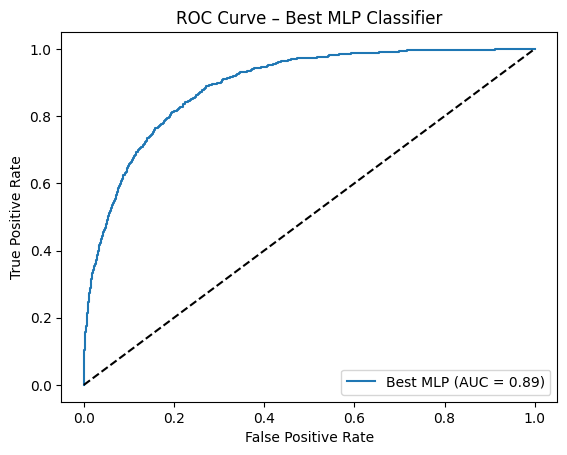

In [140]:
from sklearn.metrics import roc_curve

y_test_pred = best_mlp_tuned.predict(X_test_scaled)
y_test_proba = best_mlp_tuned.predict_proba(X_test_scaled)[:,1]

print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

roc = roc_auc_score(y_test, y_test_proba)
print("ROC AUC Score:", roc)

fpr, tpr, _ = roc_curve(y_test, y_test_proba)
plt.plot(fpr, tpr, label=f"Best MLP (AUC = {roc:.2f})")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Best MLP Classifier")
plt.legend()
plt.show()

## Comparison with Other Models

Comparing the MLP Classifier with Logistic Regression and Random Forest because they represent two strong but very different baselines. Logistic Regression helps us see how a simple linear model performs. It’s the benchmark for understanding if my neural network is actually learning something deeper or just adding complexity. On the other hand, Random Forest is a powerful nonlinear model that captures feature interactions well. By comparing against both, I can show that my MLP not only handles nonlinear patterns like Random Forest, but also generalizes better as well as understands the data instead of just memorizing it.

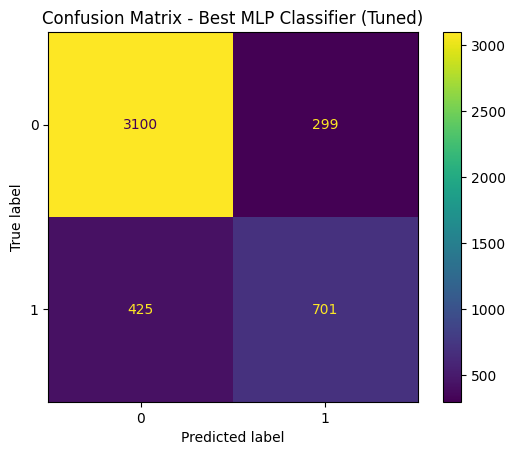

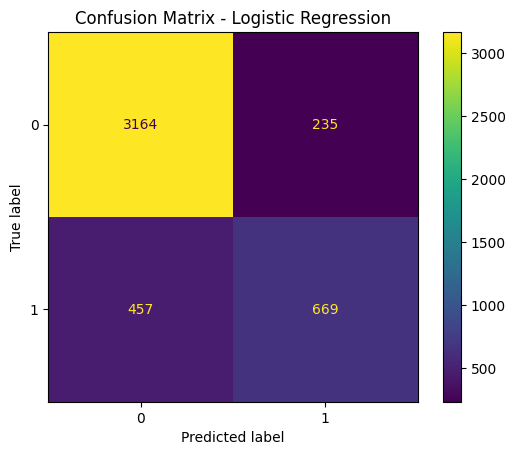

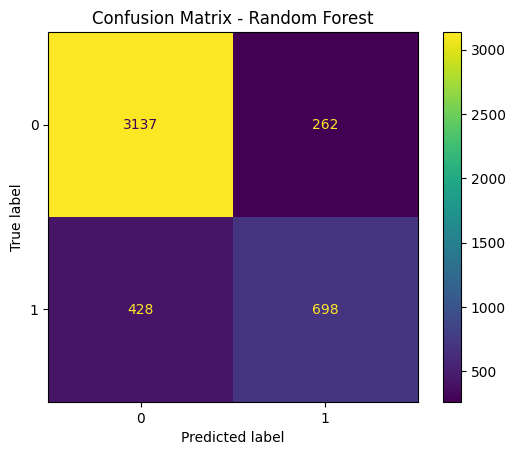

In [146]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


# Confusion Matrix for Best MLP

y_test_pred_mlp = best_mlp_tuned.predict(X_test_scaled)
cm_mlp = confusion_matrix(y_test, y_test_pred_mlp)
disp_mlp = ConfusionMatrixDisplay(confusion_matrix=cm_mlp)
disp_mlp.plot()
plt.title("Confusion Matrix - Best MLP Classifier (Tuned)")
plt.show()

# Confusion Matrix for Logistic Regression
lr = LogisticRegression(max_iter=500)
lr.fit(X_train_scaled, y_train)
y_test_pred_lr = lr.predict(X_test_scaled)
cm_lr = confusion_matrix(y_test, y_test_pred_lr)
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr)
disp_lr.plot()
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

# Confusion Matrix for Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)
y_test_pred_rf = rf.predict(X_test_scaled)
cm_rf = confusion_matrix(y_test, y_test_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf)
disp_rf.plot()
plt.title("Confusion Matrix - Random Forest")
plt.show()



In [147]:

print(f"ROC AUC - Logistic Regression: {lr_roc:.3f}")
print(f"ROC AUC - Random Forest:       {rf_roc:.3f}")
print(f"ROC AUC - MLP Classifier:      {roc:.3f}")


ROC AUC - Logistic Regression: 0.885
ROC AUC - Random Forest:       0.860
ROC AUC - MLP Classifier:      0.891


In [149]:
%%markdown

## Model ROC AUC Comparison

Based on the ROC AUC score, the MLP Classifier performed slightly better.



## Model ROC AUC Comparison

Based on the ROC AUC score, the MLP Classifier performed slightly better.
